### Importación de módulos

In [177]:
# Procesamiento de datos
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Dimensionalidad
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE

#Clustering
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Otros
from IPython.display import display
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Dataset

In [178]:
data = pd.read_csv("Crop_recommendation.csv")
display(data.head())

N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

### Análisis Descriptivo

In [179]:
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


None

N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091   298.560117

In [180]:
#---- Analisis de valores nulos ----#

# Calcular la cantidad de valores nulos y no nulos para cada columna
null_counts = data.isnull().sum()
non_null_counts = data.notnull().sum()

total_records = len(data)
info_df = pd.DataFrame({'Variable': data.columns, 'Nulos': null_counts, 'No Nulos': non_null_counts})

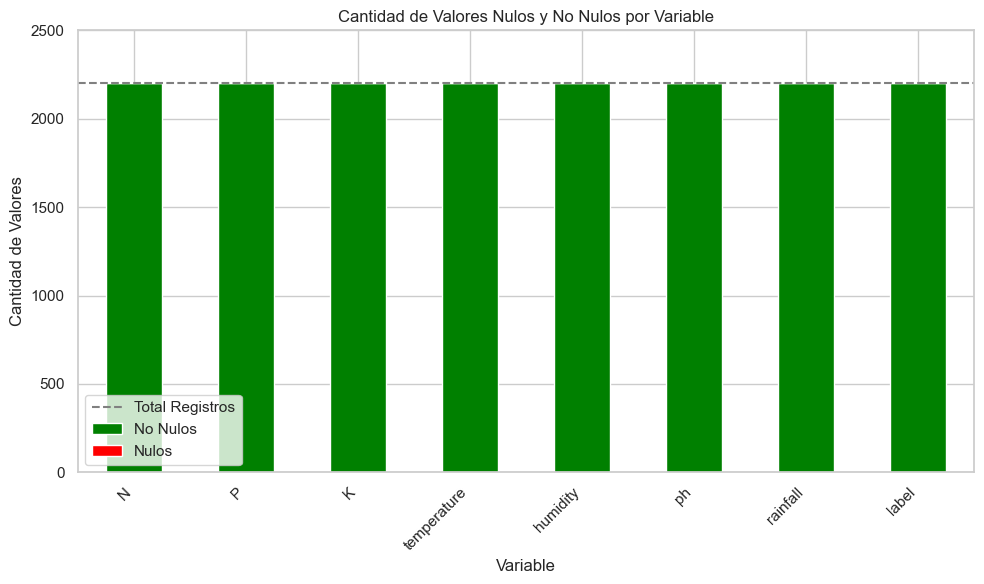

In [181]:
# Configurar el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras
info_df.plot(x='Variable', y='No Nulos', kind='bar', ax=ax, color='green', label='No Nulos')
info_df.plot(x='Variable', y='Nulos', kind='bar', ax=ax, color='red', label='Nulos', bottom=non_null_counts)

# Configurar la línea punteada horizontal
plt.axhline(y=total_records, color='gray', linestyle='--', label='Total Registros')

# Configurar etiquetas y título
ax.set_xlabel('Variable')
ax.set_ylabel('Cantidad de Valores')
ax.set_title('Cantidad de Valores Nulos y No Nulos por Variable')
ax.set_ylim([0, 2500])

plt.legend()
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

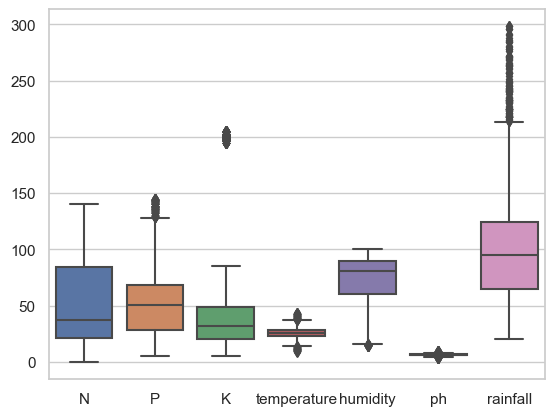

In [182]:
#--- Outliers ---#
sns.boxplot(data)
plt.show()

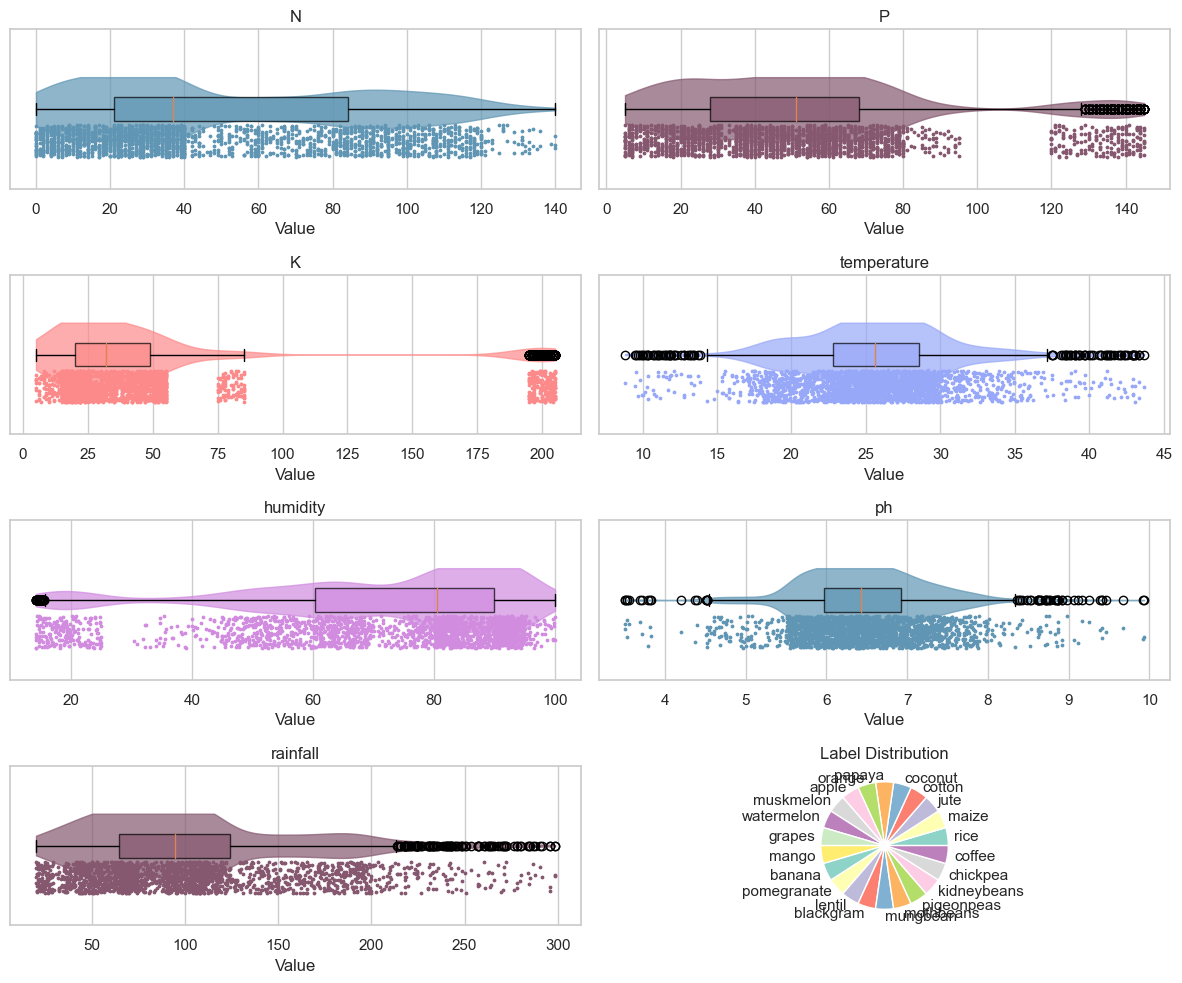

In [183]:
#--- Estadisticos de forma grafica --#
nums = data[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
labels = data['label']

# Configuración del estilo
sns.set(style="whitegrid")
colors = ['#6096B4', '#85586F', '#FD8A8A', '#98A8F8', '#D18CE0', '#6096B4', '#85586F', '#FD8A8A']

# Crear subplots con 2 columnas
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))

# Iterar a través de las variables y crear un gráfico para cada una
for idx, column in enumerate(nums.columns):
    ax = axes[idx // 2, idx % 2]  # Calcular la posición de la subtrama

    # Boxplot
    bp = ax.boxplot(nums[column], patch_artist=True, vert=False)
    bp['boxes'][0].set_facecolor(colors[idx])
    bp['boxes'][0].set_alpha(0.7)

    # Violin plot
    vp = ax.violinplot(nums[column], points=500, showmeans=False, showextrema=False, showmedians=False, vert=False)
    vp['bodies'][0].get_paths()[0].vertices[:, 1] = np.clip(vp['bodies'][0].get_paths()[0].vertices[:, 1], 0.8, 1.2)
    vp['bodies'][0].set_color(colors[idx])
    vp['bodies'][0].set_alpha(0.7)

    # Scatter plot
    y = np.full(len(nums[column]), 0.8) + np.random.uniform(low=-.1, high=.1, size=len(nums[column]))
    ax.scatter(nums[column], y, s=3, c=colors[idx])

    # Configurar títulos y etiquetas
    ax.set_title(column)
    ax.set_yticks([])
    ax.set_xlabel("Value")
# Añadir el gráfico de pastel en el último eje
ax_pie = axes[3, 1]
label_counts = labels.value_counts()
ax_pie.pie(label_counts, labels=label_counts.index, colors=sns.color_palette('Set3', len(label_counts)))
ax_pie.set_title("Label Distribution")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

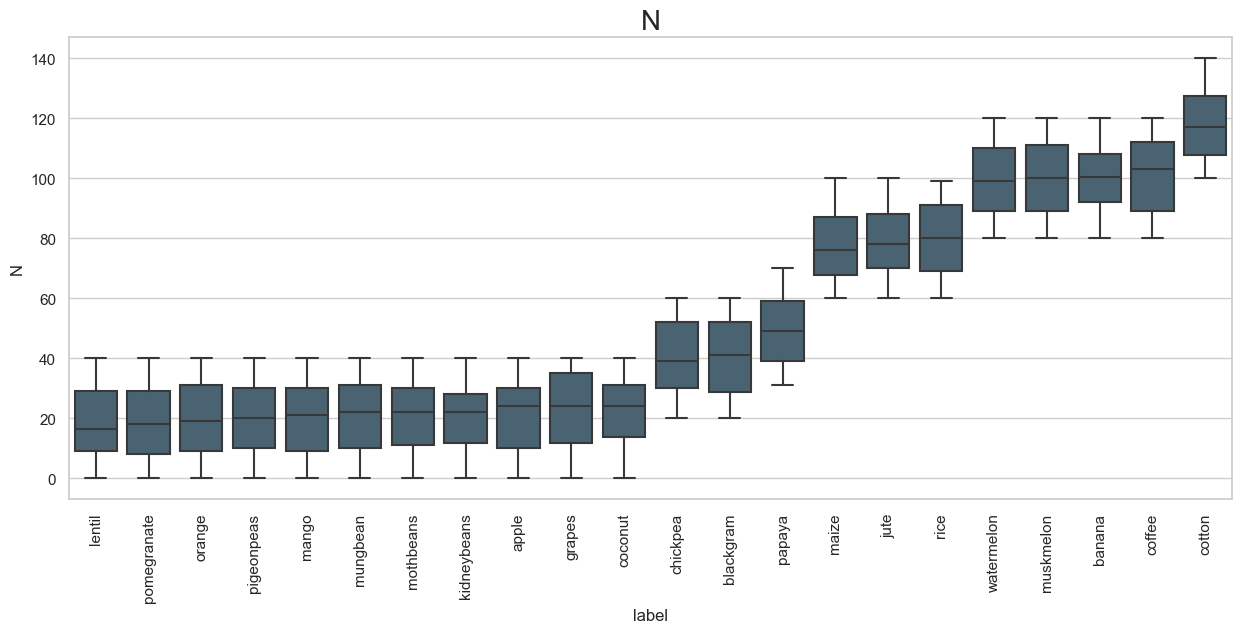

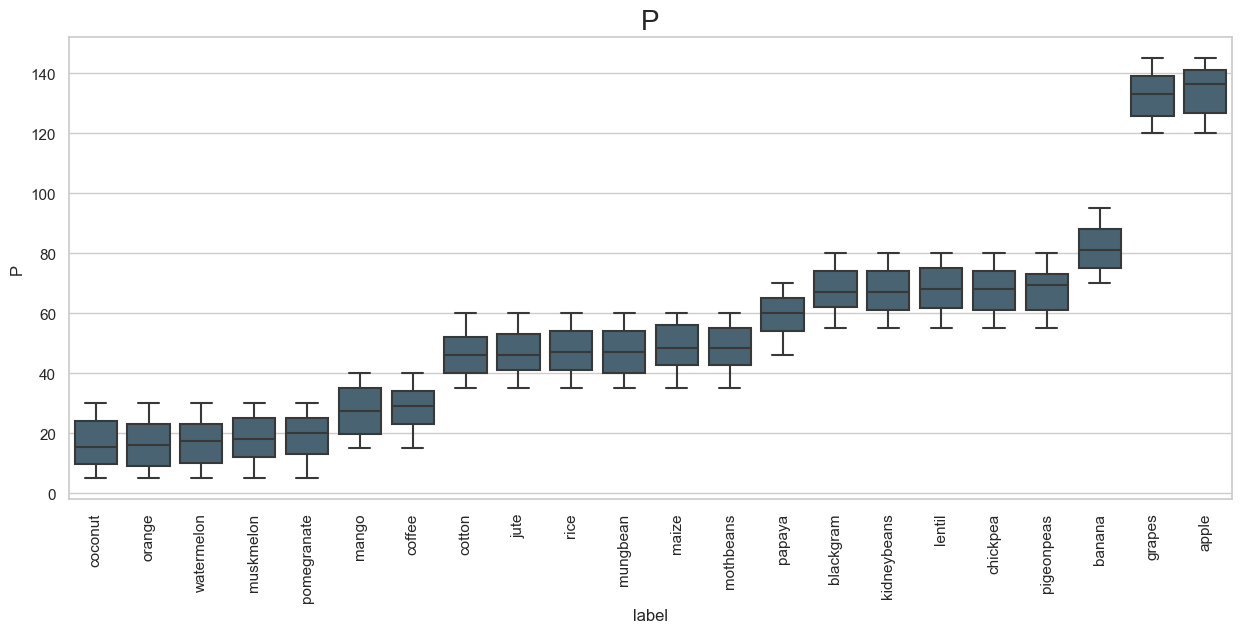

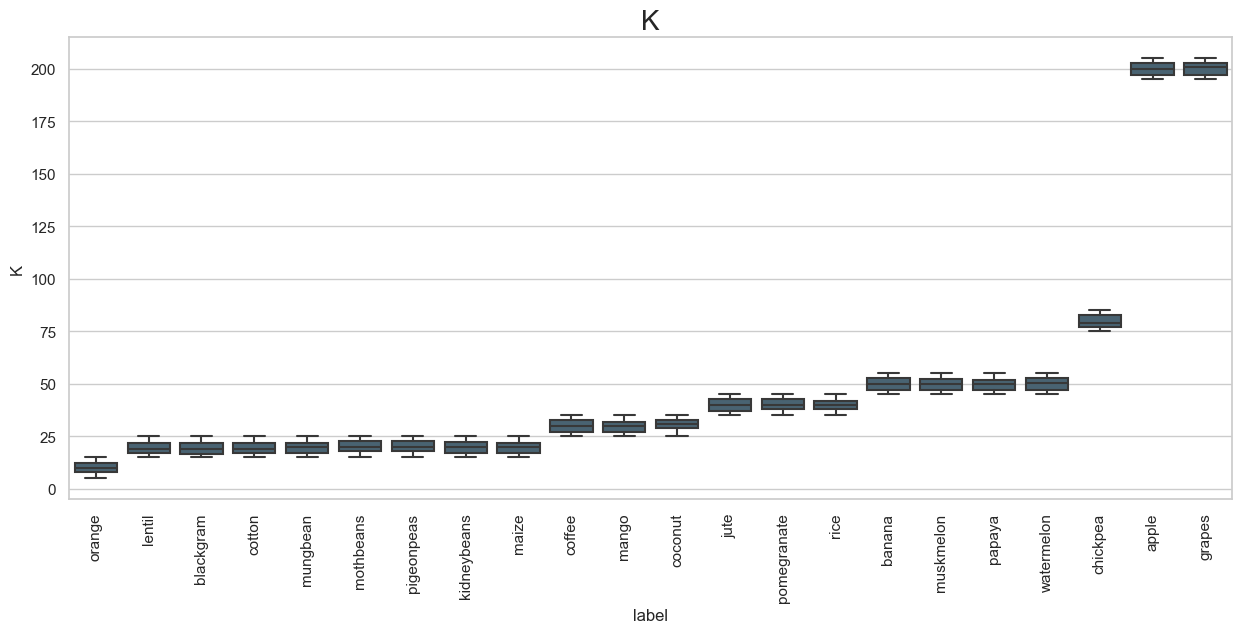

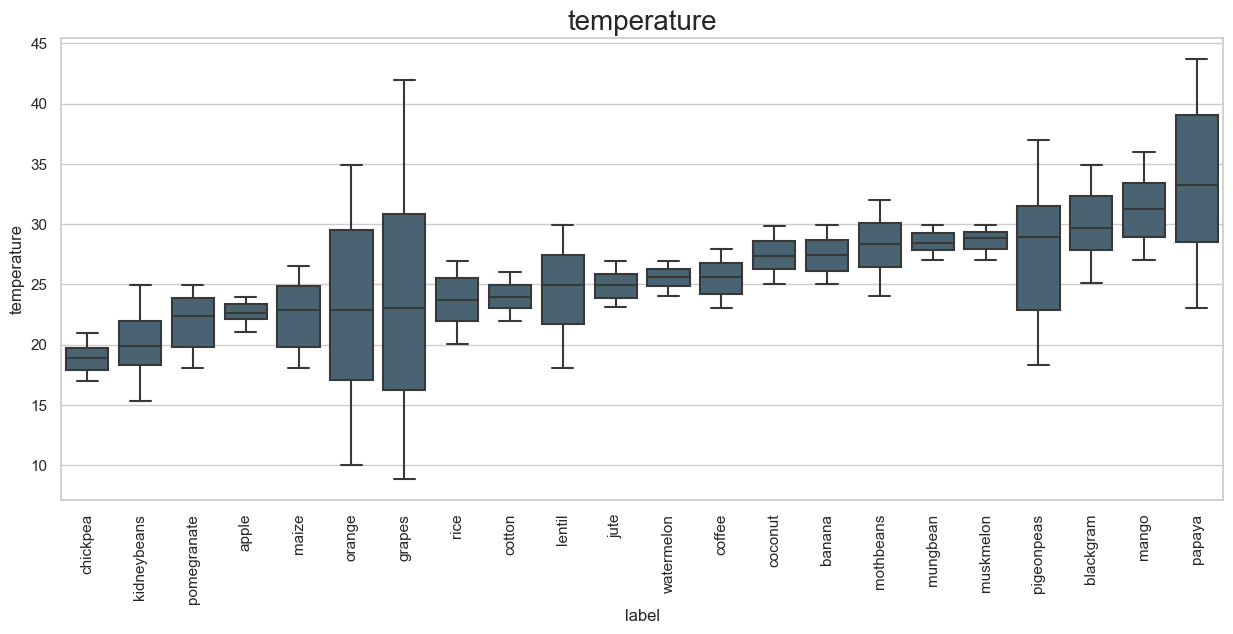

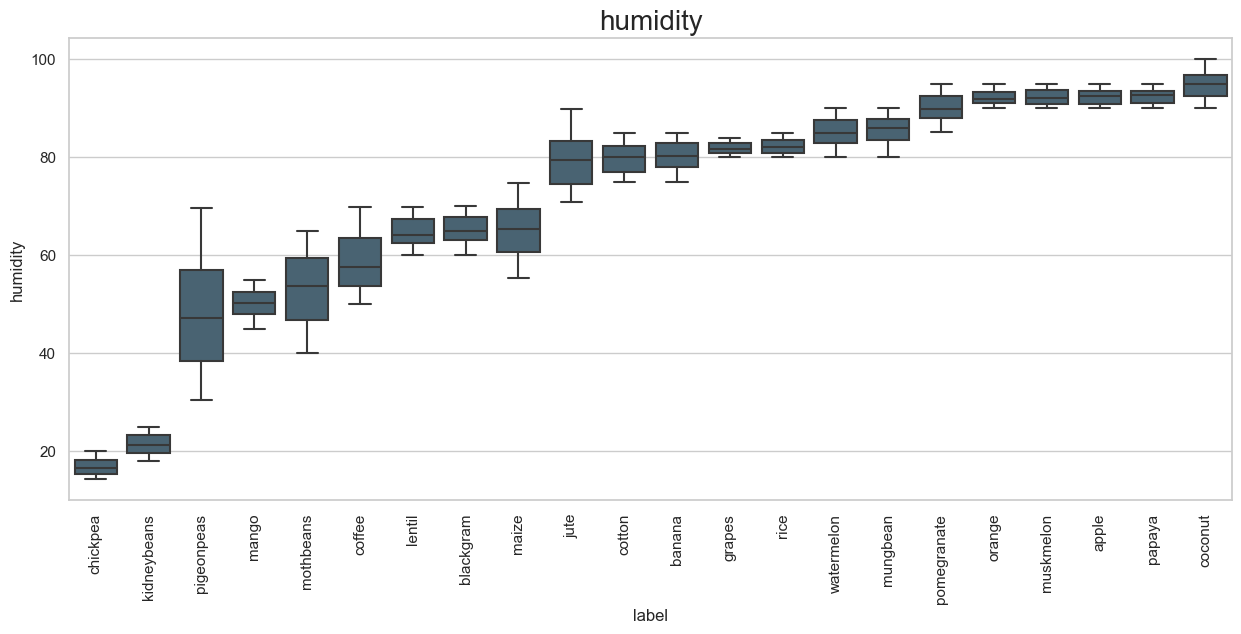

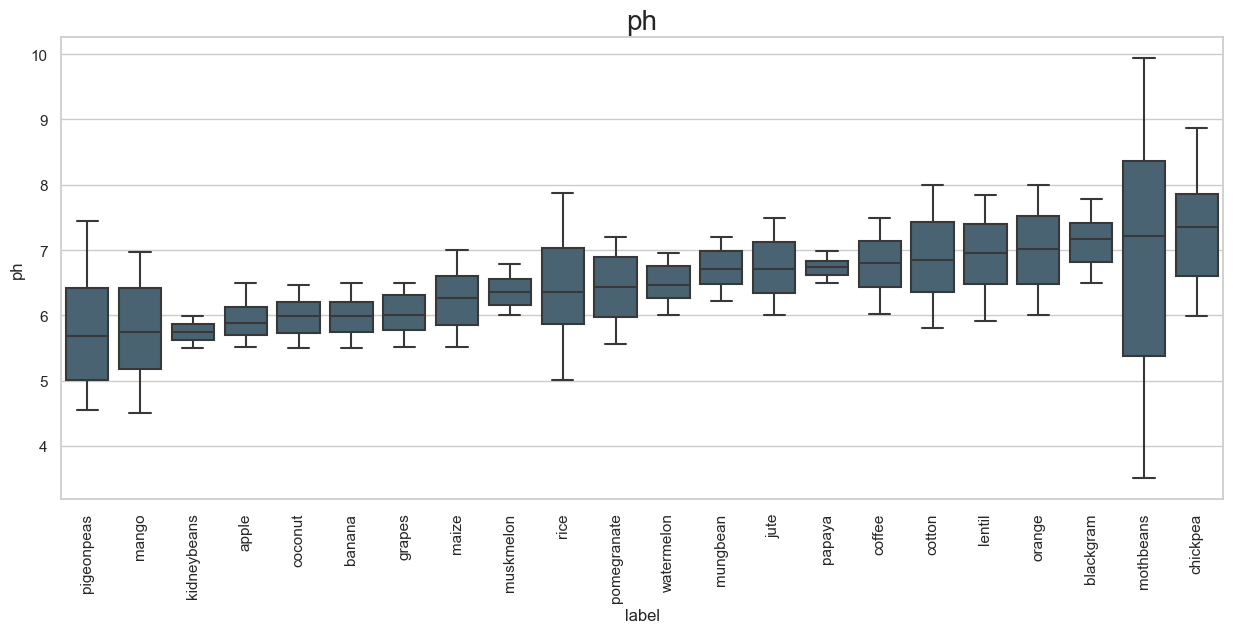

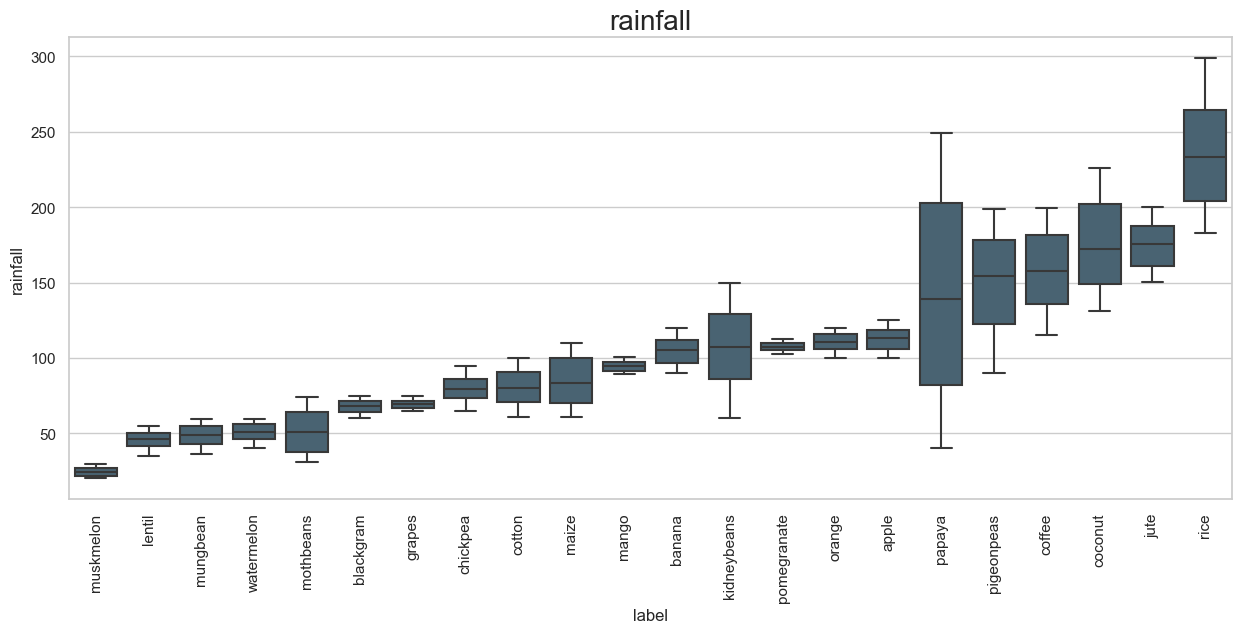

In [184]:
### Graficos para entender los outliers ###

cols=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

for col in cols:
    plt.figure(figsize=(15,6))
    plt.title(col,fontsize=20)
    
    df = data.groupby('label').agg({col:np.median}).reset_index().sort_values([col])
    g = sns.boxplot(x=data['label'],y=data[col],color="#426579",data=data,order = df.label.values)
    g.tick_params(axis='x', labelrotation=90)
    g.tick_params(axis='y')
    
    plt.show()

#### Estandarización de Datos

In [185]:
standar = StandardScaler()
robust = RobustScaler()

# Escalar los datos de forma robusta (con menor efecto sobre atipicos)
data_standar = pd.DataFrame(standar.fit_transform(nums), columns=nums.columns)
data_scaled = pd.DataFrame(robust.fit_transform(data_standar), columns=data_standar.columns)

display('Original', data.describe()[1:3])
display('Escalado', data_scaled.describe()[1:3])

'Original'

N          P          K  temperature   humidity        ph  \
mean  50.551818  53.362727  48.149091    25.616244  71.481779  6.469480   
std   36.917334  32.985883  50.647931     5.063749  22.263812  0.773938   

        rainfall  
mean  103.463655  
std    54.958389

'Escalado'

N         P         K  temperature  humidity        ph  rainfall
mean  0.214258  0.059068  0.556865     0.003030 -0.302874  0.046678  0.143949
std   0.583673  0.824647  1.746480     0.874224  0.749956  0.813003  0.920332

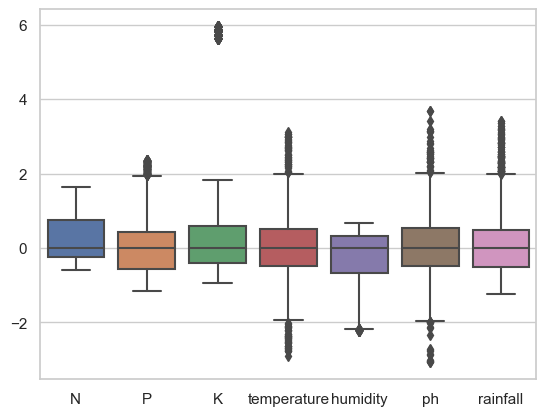

In [186]:
#--- Distribuciones ---#
sns.boxplot(data_scaled)
plt.show()

#### Correlaciones

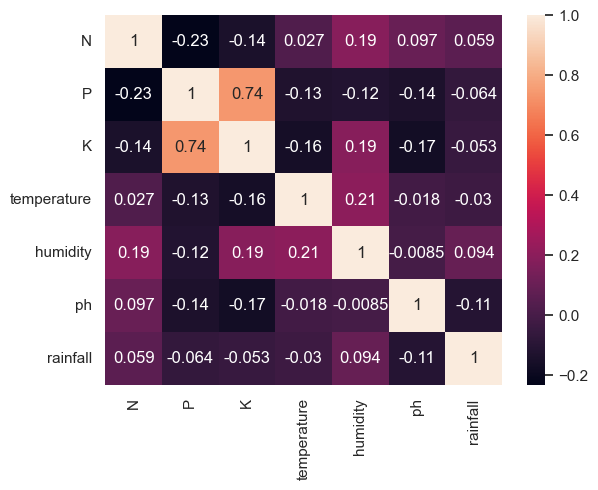

/home/simon/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



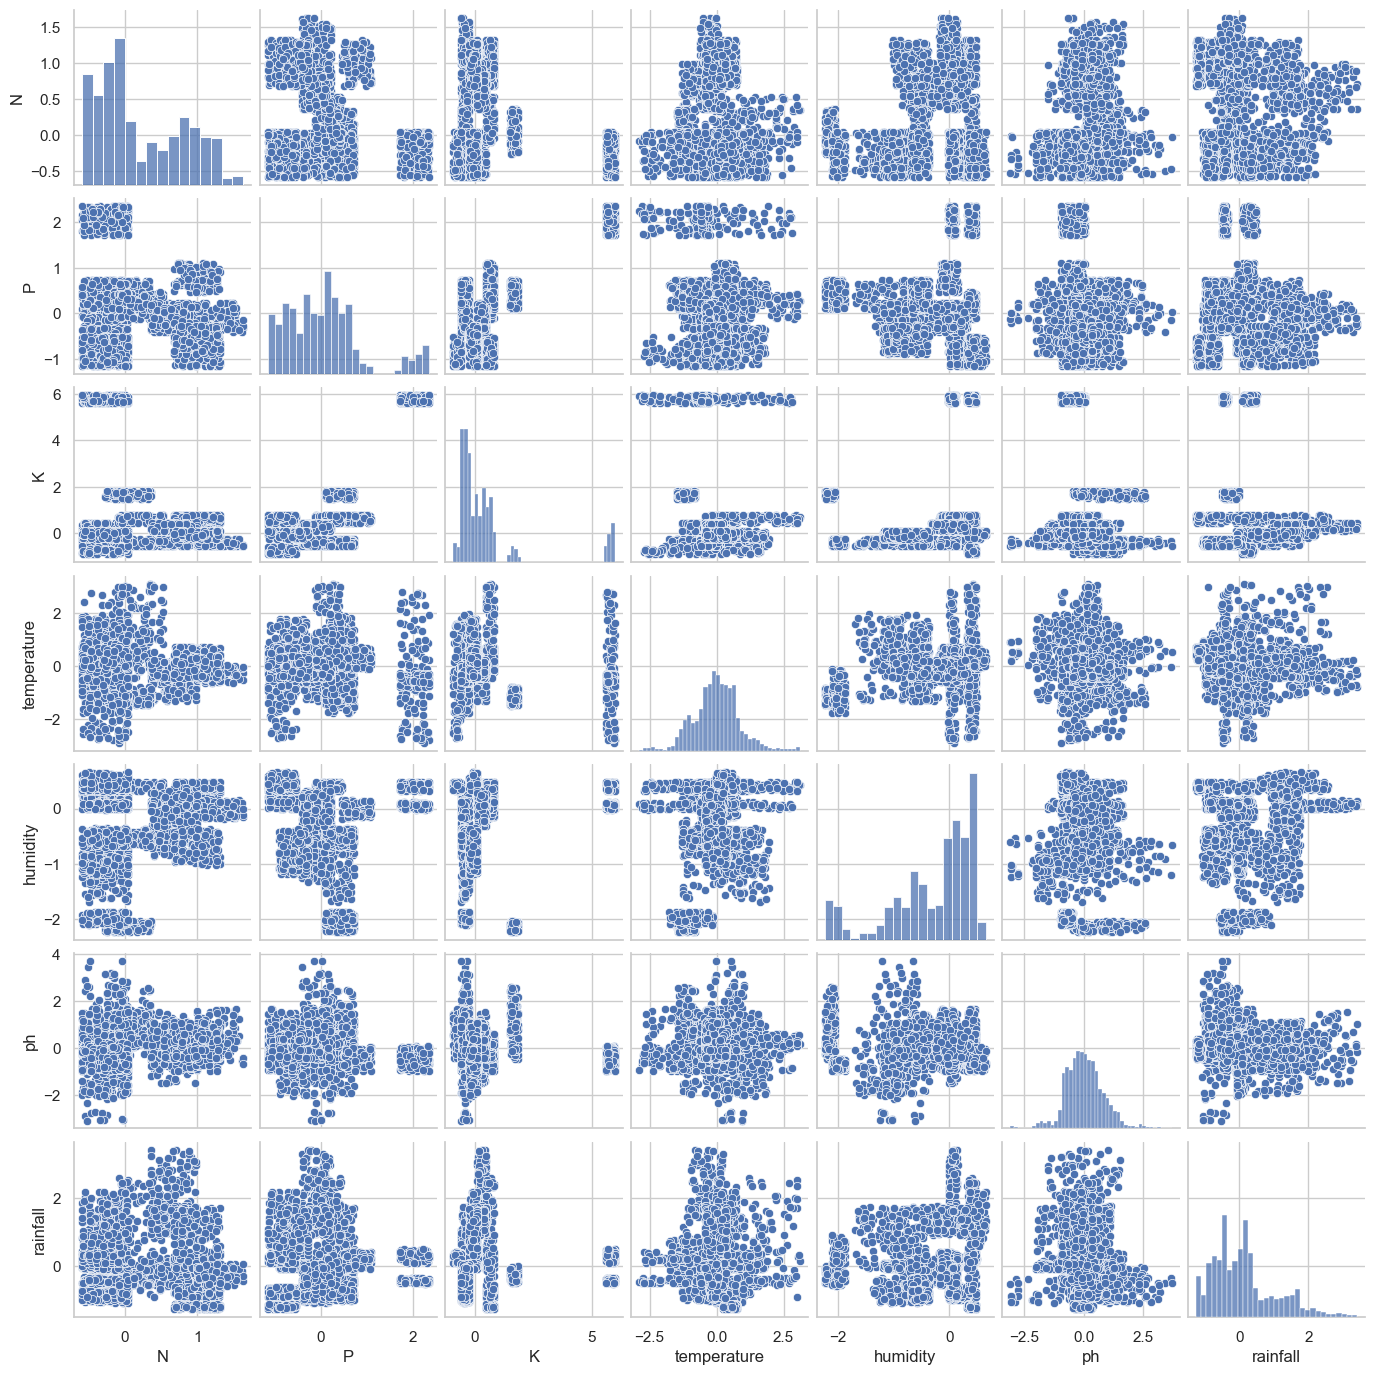

(<seaborn.axisgrid.PairGrid at 0x7fc01148cdf0>, None)

In [187]:
# heatmap
sns.heatmap(data_scaled.corr(), annot=True), plt.show()

# distribuciones todos vs todos
sns.pairplot(data=data_scaled, height=2), plt.show()

### PCA

In [188]:
#--- Obtencion de los componentes ---#
pca = PCA()

pca_result = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i, _ in enumerate(data_scaled.columns)])
pca_df["label"] = data["label"]

display(pca_df.head())

PC1       PC2       PC3       PC4       PC5       PC6       PC7 label
0 -0.257065  1.452504 -1.043126 -0.794433 -0.257403 -0.327161 -0.055498  rice
1 -0.255927  1.588976 -1.106424 -1.154170  0.412224 -0.305093 -0.321384  rice
2 -0.274538  1.917839 -1.098214 -1.835532  1.144650  0.125556 -0.153844  rice
3 -0.556926  2.045289 -0.511523 -0.992085  0.666491 -0.150440  0.258331  rice
4 -0.404106  1.913368 -1.467324 -1.884355  0.624299 -0.061547  0.010146  rice

In [189]:
#--- Explicabilidad de los componentes ---#

varianza = np.cumsum(pca.explained_variance_ratio_)

acum = pd.DataFrame({"Component": pca_df.columns[:-1],
                     "EigenValues": pca.explained_variance_,
                     "PropVar": pca.explained_variance_ratio_,
                     "VarAcum": varianza})
display(acum)

Component  EigenValues   PropVar   VarAcum
0       PC1     3.528097  0.510904  0.510904
1       PC2     0.899133  0.130203  0.641107
2       PC3     0.834330  0.120819  0.761927
3       PC4     0.647829  0.093812  0.855739
4       PC5     0.513823  0.074407  0.930146
5       PC6     0.289003  0.041851  0.971996
6       PC7     0.193382  0.028004  1.000000

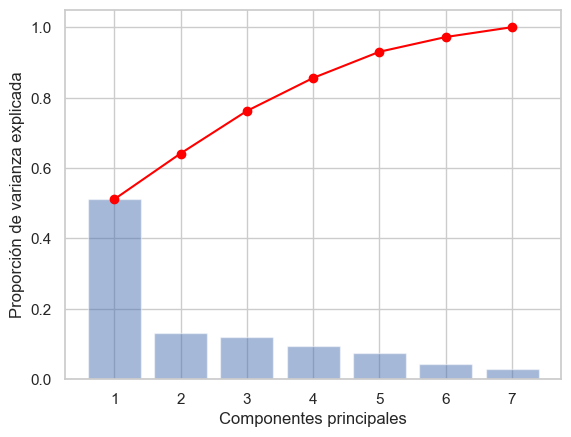

In [190]:
#--- grafico de explicabilidad ---#

plt.bar(range(1, 8), pca.explained_variance_ratio_, alpha=0.5, align="center")
plt.plot(range(1, 8), varianza, marker="o" ,color="red")
plt.ylabel("Proporción de varianza explicada")
plt.xlabel("Componentes principales")
plt.show()

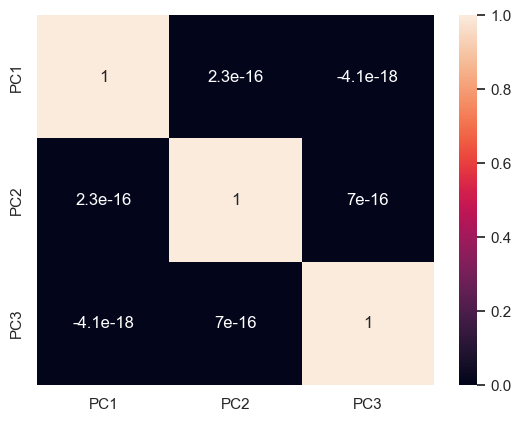

In [191]:
#--- Seleccion de componentes ---#

pcas = pca_df[["PC1", "PC2", "PC3"]]
sns.heatmap(pcas.corr(), annot=True)
plt.show()

In [192]:
#--- Visualizar la distribucion de las componentes por clase ---#
fig = px.scatter_3d(pca_df,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color='label',
                    labels={"color":"label"})
fig.show()

### ISOMAP

In [193]:
#--- Definicion de ISOMAP method ---#

def isomap_vars(n_neighbors, n_components, comp1, comp2, comp3=None):
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)

    isomap.fit(data_scaled)
    datos_isomap = isomap.transform(data_scaled)

    isomap_df = pd.DataFrame(datos_isomap, columns=[f"C{i + 1}" for i in range(n_components)])
    isomap_df["label"] = data["label"]

    if comp3 is None:
        grupos = isomap_df.groupby("label")

        for nombre, grupo in grupos:
            plt.title(f"ISOMAP - Neighs = {n_neighbors} - Comps = {n_components}")
            plt.xlabel(comp1), plt.ylabel(comp2)
            plt.plot(grupo[comp1], grupo[comp2], marker="o", linestyle="", markersize=5, label=nombre)
    else:
        return isomap_df

/home/simon/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:359: UserWarning:

The number of connected components of the neighbors graph is 12 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/home/simon/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/simon/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/simon/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/simon/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_mat

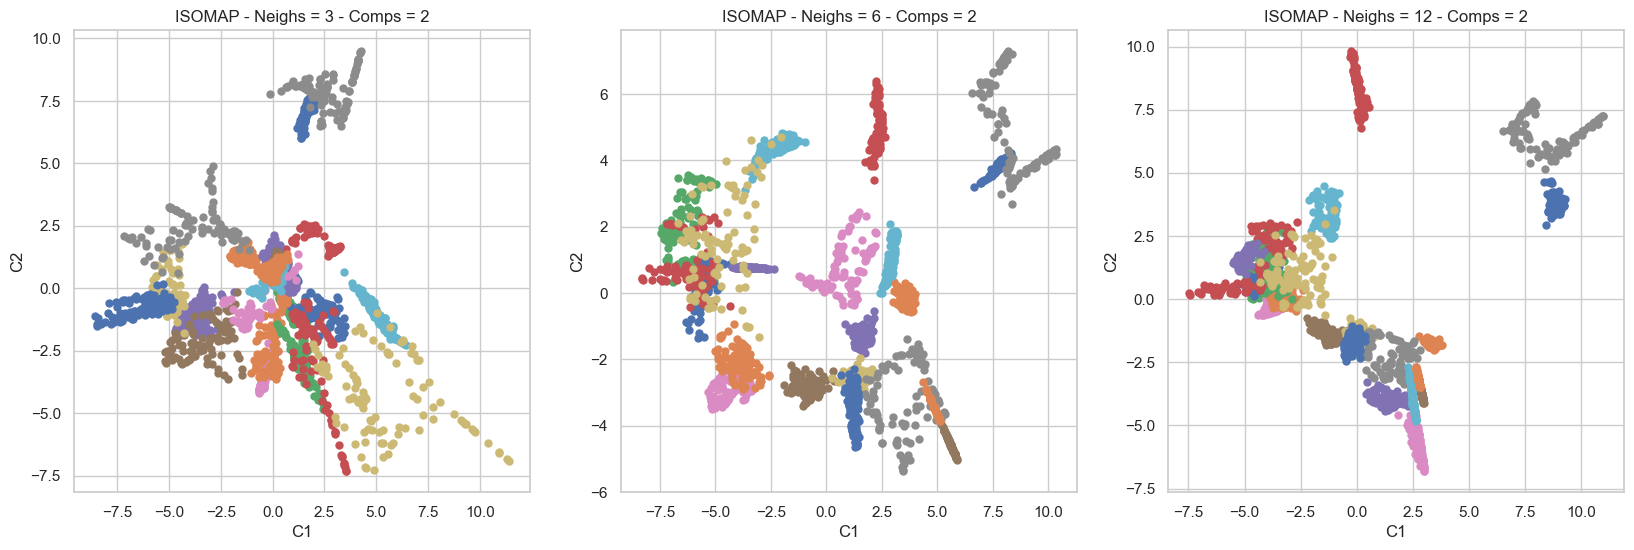

In [194]:
#--- Variacion de la cantidad de vecinos ---#

fig, axes = plt.subplots(ncols=3, figsize=(20, 6))

plt.sca(axes[0])
isomap_vars(3, 2, "C1", "C2")

plt.sca(axes[1])
isomap_vars(6, 2, "C1", "C2")

plt.sca(axes[2])
isomap_vars(12, 2, "C1", "C2")

plt.show()

In [195]:
#--- Variciacion usando tres componentes ---#

isomap_df = isomap_vars(12, 3, 'C1', 'C2', 'C3')

fig = px.scatter_3d(isomap_df,
                    x='C1',
                    y='C2',
                    z='C3',
                    color='label',
                    labels={"color":"label"})
fig.show()

/home/simon/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:359: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/home/simon/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/simon/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/simon/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [196]:
### Algortimo TSNE ###

#--- Definicion del algoritmo ---#

def apply_tsne(data, n_components, perplexity, n_iter):
    tsne = TSNE(n_components=n_components, verbose=1, perplexity=perplexity, n_iter=n_iter)
    return tsne.fit_transform(data)

def plot_tsne(results, title, ax):
    sns.scatterplot(
        x=results[:, 0], y=results[:, 1],
        hue=data.label,
        palette=sns.color_palette("hls", 22),
        alpha=0.9, legend=False, ax=ax)

    ax.set_title(title)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.001s...
[t-SNE] Computed neighbors for 2200 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.416994
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.581951
[t-SNE] KL divergence after 300 iterations: 1.102441
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.001s...
[t-SNE] Computed neighbors for 2200 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.416994
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.339699
[t-SNE] KL divergence after 300 iterations: 0.941120


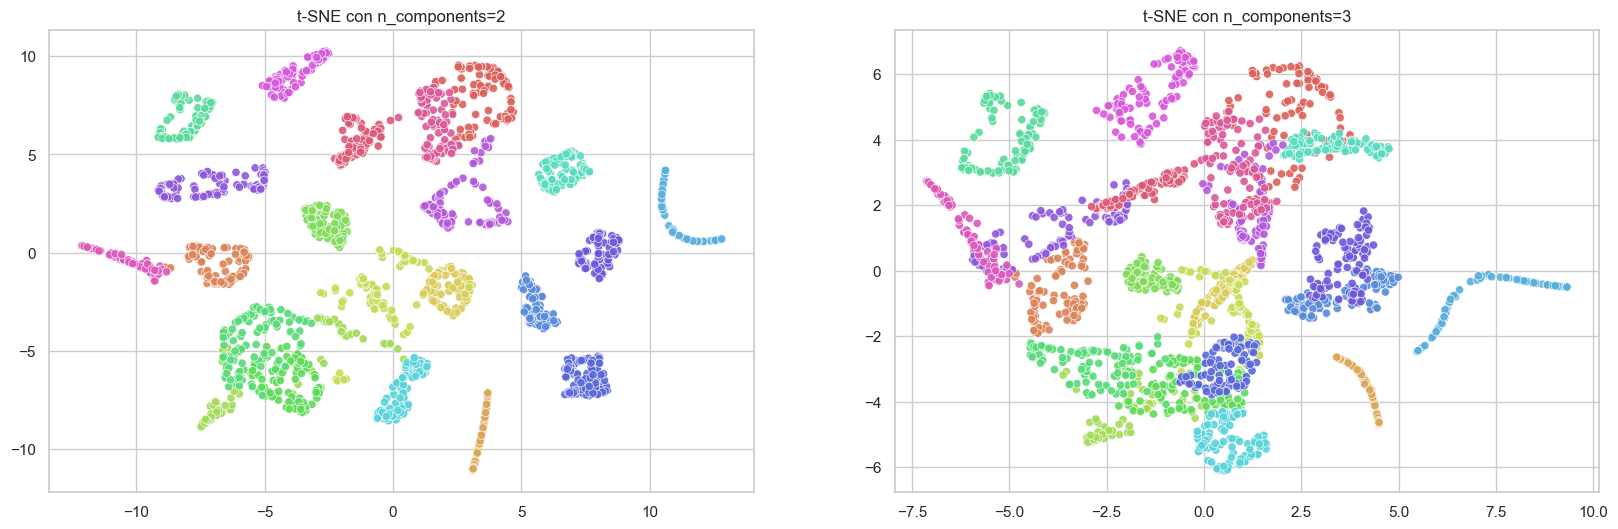

In [197]:
#--- Prueba con diferentes valores de n_components ---#

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

for i, n_components in enumerate([2, 3]):
    results = apply_tsne(data_scaled, n_components, 40, 300)
    plot_tsne(results, f"t-SNE con n_components={n_components}", axes[i])

plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.002s...
[t-SNE] Computed neighbors for 2200 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.190368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.104034
[t-SNE] KL divergence after 300 iterations: 2.440866
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.001s...
[t-SNE] Computed neighbors for 2200 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.346793
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.314484
[t-SNE] KL divergence after 300 iterations: 1.363252
[t

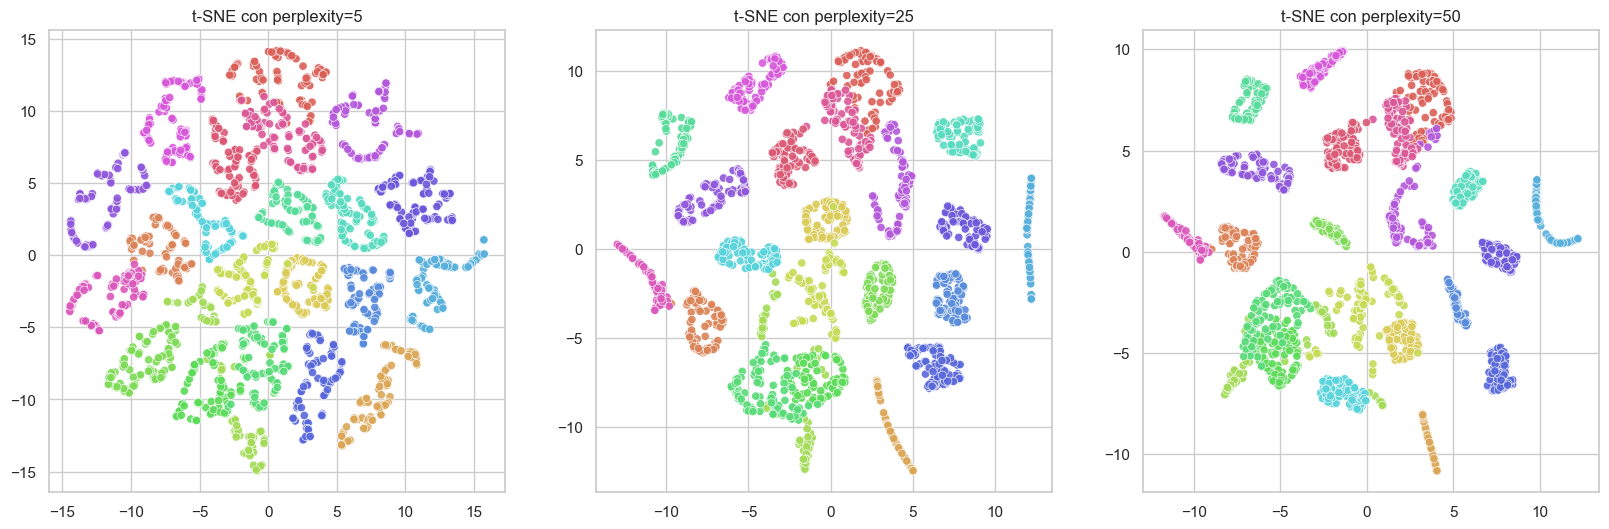

In [198]:
#--- Prueba con diferentes valores de perplexity ---#
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))
for i, perplexity in enumerate([5, 25, 50]):
    results = apply_tsne(data_scaled, 2, perplexity, 300)
    plot_tsne(results, f"t-SNE con perplexity={perplexity}", axes[i])

plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.001s...
[t-SNE] Computed neighbors for 2200 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.416994
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.581951
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.001s...
[t-SNE] Computed neighbors for 2200 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sam

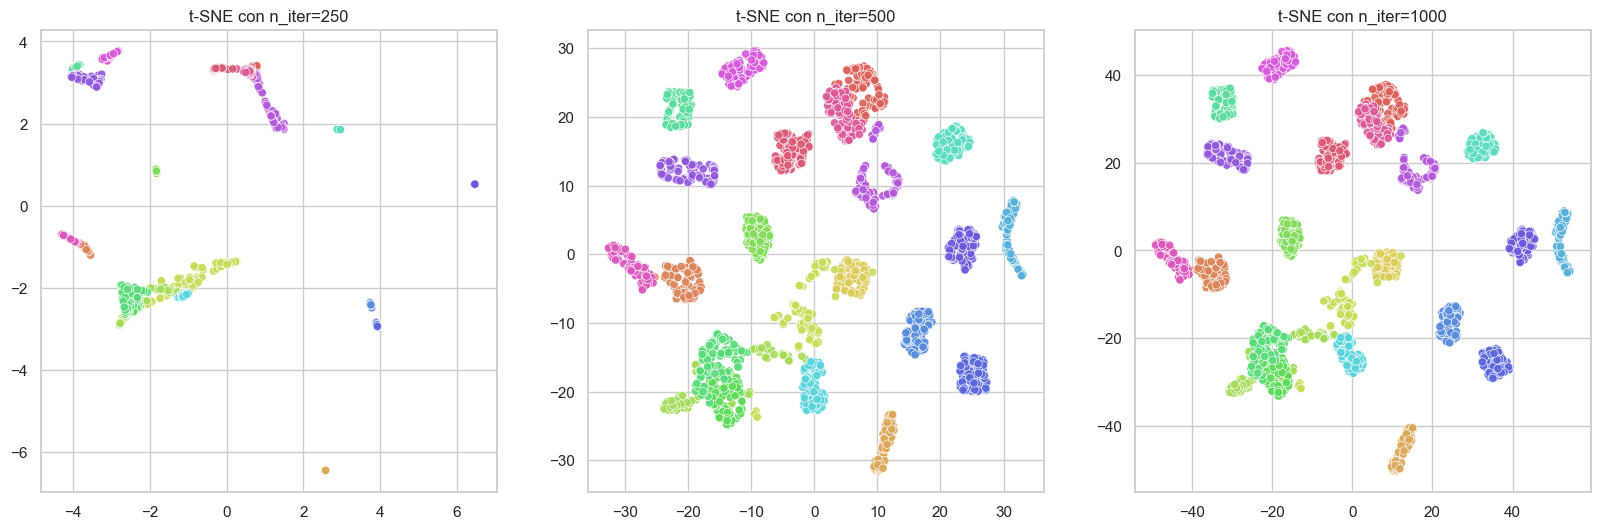

In [199]:
#--- Prueba con diferentes valores de n_iter ---#
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))
for i, n_iter in enumerate([250, 500, 1000]):
    results = apply_tsne(data_scaled, 2, 40, n_iter)
    plot_tsne(results, f"t-SNE con n_iter={n_iter}", axes[i])

plt.show()

### KMeans

In [200]:
ranges = range(1, data["label"].unique().shape[0])
kmeans_arr = [KMeans(n_clusters=i) for i in ranges]
scores_arr = [kmeans.fit(data_scaled).score(data_scaled) for kmeans in kmeans_arr]

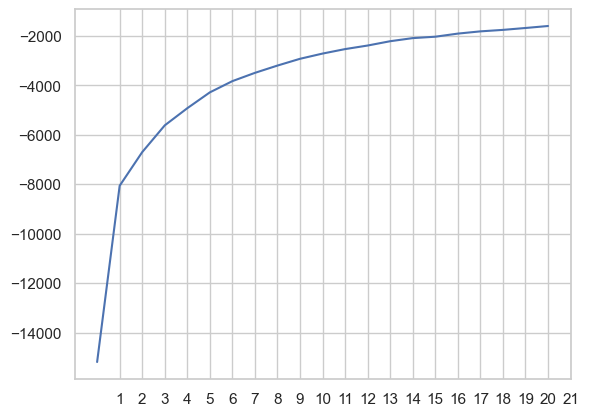

In [201]:
sns.lineplot(scores_arr)
plt.xticks(ranges)
plt.show()

Viendo el gráfico se puede concluir que los mejors valores para K pueden ser 3, 4, o 5

In [202]:
optimalk = OptimalK(n_jobs=1, n_iter=20)

In [203]:
optimalk(data_scaled, n_refs=100, cluster_array=range(1, data["label"].unique().shape[0]))

/home/simon/.local/lib/python3.10/site-packages/scipy/cluster/vq.py:602: UserWarning:

One of the clusters is empty. Re-run kmeans with a different initialization.



20

In [204]:
k_optimo = optimalk(data_scaled, n_refs=50, cluster_array=range(1, data["label"].unique().shape[0]))
k_optimo

21

In [205]:
kmeans_data4 = data_scaled.copy()
kmeans_data4["tag"] = kmeans_arr[3].predict(data_scaled)

In [206]:
px.scatter_3d(kmeans_data4, x="temperature", y="rainfall", z="humidity", color="tag")

In [207]:
kmeans_data5 = data_scaled.copy()
kmeans_data5["tag"] = kmeans_arr[4].predict(data_scaled)
px.scatter_3d(kmeans_data5, x="temperature", y="rainfall", z="humidity", color="tag")

In [208]:
kmeans_data20 = data_scaled.copy()
kmeans_data20["tag"] = kmeans_arr[19].predict(data_scaled)
px.scatter_3d(kmeans_data20, x="temperature", y="rainfall", z="humidity", color="tag")

In [209]:
cluster = sch.linkage(data_scaled, method="ward")

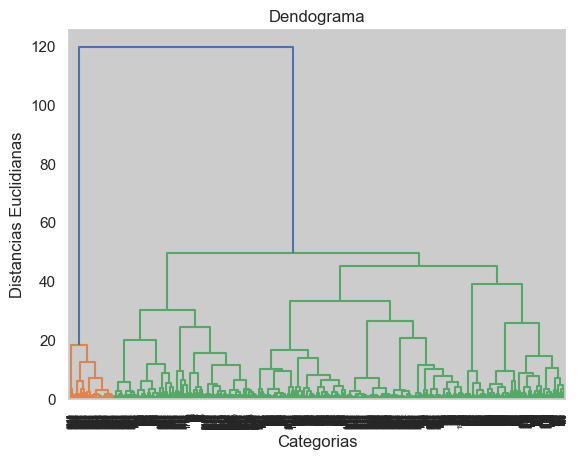

In [210]:
dendograma = sch.dendrogram(cluster)
plt.title("Dendograma")
plt.xlabel("Categorias")
plt.ylabel("Distancias Euclidianas")
plt.show()

In [211]:
ranges = range(2, data["label"].unique().shape[0])
ac_arr = [AgglomerativeClustering(n_clusters=i, metric="euclidean", linkage="ward") for i in ranges]
y_ac_arr = [ac.fit_predict(data_scaled) for ac in ac_arr]

In [212]:
dendo_data = data_scaled.copy()
dendo_data["tag"] = y_ac

In [213]:
px.scatter_3d(dendo_data, x="temperature", y="rainfall", z="humidity", color="tag")

In [214]:
s_scores = [silhouette_score(data_scaled, y_ac) for y_ac in y_ac_arr]
s_scores_df = pd.DataFrame(s_scores, columns=["s_score"], index=ranges)

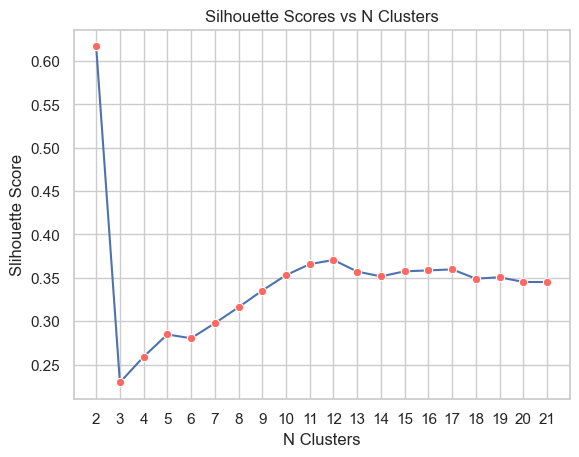

In [215]:
sns.lineplot(s_scores_df, x=s_scores_df.index, y="s_score", marker="o", markerfacecolor="#ff6961").set(title="Silhouette Scores vs N Clusters", xlabel="N Clusters", ylabel="Slihouette Score")
plt.xticks(ranges)
plt.show()

In [216]:
k_optimo = optimalk(data_scaled, n_refs=50, cluster_array=ranges)
k_optimo

21